## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
import pandas as pd

In [6]:
from sqlalchemy import create_engine
import pandas as pd

user = "postgres"
password = "kavya"
host = "localhost"
port = "5432"
database = "salarydb"

# Connect
engine = create_engine(f"postgresql+pg8000://{user}:{password}@{host}:{port}/{database}")

# Load CSV
df = pd.read_csv("Software_Salaries.csv")

# Push to PostgreSQL
df.to_sql("software_salaries", engine, if_exists="replace", index=False)

print("✅ CSV uploaded successfully to salarydb!")


✅ CSV uploaded successfully to salarydb!


## Preprocessing 

In [7]:
# Load data directly from PostgreSQL
df = pd.read_sql("SELECT * FROM software_salaries", engine)

# Preview
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   job_title           100000 non-null  object 
 1   experience_level    80000 non-null   object 
 2   employment_type     76016 non-null   object 
 3   company_size        100000 non-null  object 
 4   company_location    100000 non-null  object 
 5   remote_ratio        100000 non-null  int64  
 6   salary_currency     100000 non-null  object 
 7   years_experience    100000 non-null  int64  
 8   base_salary         100000 non-null  float64
 9   bonus               100000 non-null  int64  
 10  stock_options       100000 non-null  int64  
 11  total_salary        100000 non-null  float64
 12  salary_in_usd       100000 non-null  float64
 13  currency            100000 non-null  object 
 14  education           0 non-null       object 
 15  skills              0 non-null     

,job_title,experience_level,employment_type,company_size,company_location,remote_ratio,salary_currency,years_experience,base_salary,bonus,stock_options,total_salary,salary_in_usd,currency,education,skills,conversion_rate,adjusted_total_usd
0,Data Analyst,Mid,Contract,Medium,Germany,0,INR,13,68407.451747,1100,19325,88832.451747,1065.989421,USD,None,None,1.000,88832.451747
1,DevOps Engineer,Mid,Contract,Small,India,100,GBP,9,64193.117775,2194,19164,85551.117775,111216.453107,EUR,None,None,1.100,94106.229552
2,Research Scientist,Lead,None,Medium,Germany,0,EUR,19,136071.842899,3206,12735,152012.842899,167214.127189,EUR,None,None,1.100,167214.127189
3,Software Engr,Lead,Full-time,Large,India,50,INR,7,141850.905335,9594,11158,162602.905335,19512.348640,USD,None,None,1.000,162602.905335
4,Software Engr,Lead,Intern,Large,Germany,100,INR,10,121841.163226,6796,806,129443.163226,1553.317959,INR,None,None,0.012,1553.317959


In [8]:
df['job_title'].value_counts().head(20)


job_title
Data Analyst             16857
DevOps Engineer          16764
Research Scientist       16552
Sofware Engneer           5755
Software Engr             5622
Dt Scientist              5574
Softwre Engineer          5574
Data Scienist             5564
ML Engr                   5512
Data Scntist              5499
ML Enginer                5445
Machine Learning Engr     5282
Name: count, dtype: int64

In [9]:
# Provided mapping of inconsistent job titles
job_title_map = {
    'sofware engneer': 'Software Engineer',
    'software engr': 'Software Engineer',
    'softwre engineer': 'Software Engineer',
    'ml engr': 'ML Engineer',
    'ml enginer': 'ML Engineer',
    'machine learning engr': 'ML Engineer',
    'dt scientist': 'Data Scientist',
    'data scntist': 'Data Scientist',
    'data scienist': 'Data Scientist',
}

# Custom transformer to clean and standardize job titles
class JobTitleNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = {k.lower().strip(): v for k, v in mapping.items()}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['job_title'] = X['job_title'].str.lower().str.strip()
        X['job_title'] = X['job_title'].apply(lambda title: self.mapping.get(title, title))
        X['job_title'] = X['job_title'].str.title()
        return X

# Assume df is your original DataFrame with many job titles
# Example (you would already have this loaded)
# df = pd.read_csv('your_file.csv')

# Pipeline to normalize job titles
pipeline_job_title = Pipeline([
    ('normalize_titles', JobTitleNormalizer(mapping=job_title_map))
])

# Apply pipeline
df_clean = pipeline_job_title.fit_transform(df)

# Get value counts
job_title_counts = df_clean['job_title'].value_counts()
print(job_title_counts.head(10))  # You can display full list if needed


job_title
Software Engineer     16951
Data Analyst          16857
Devops Engineer       16764
Data Scientist        16637
Research Scientist    16552
Ml Engineer           16239
Name: count, dtype: int64


In [10]:
# Drop duplicates
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop_duplicates().reset_index(drop=True)


In [11]:
# Drop irrelevant columns
df.drop(columns=['education', 'skills'], inplace=True)

In [12]:
# Handle missing categorical values 
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.experience_mode = X['experience_level'].mode()[0]
        self.employment_mode = X['employment_type'].mode()[0]
        return self
    
    def transform(self, X):
        X = X.copy()
        X['experience_level'] = X['experience_level'].fillna(self.experience_mode)
        X['employment_type'] = X['employment_type'].fillna(self.employment_mode)
        return X

In [13]:
df.head()

,job_title,experience_level,employment_type,company_size,company_location,remote_ratio,salary_currency,years_experience,base_salary,bonus,stock_options,total_salary,salary_in_usd,currency,conversion_rate,adjusted_total_usd
0,Data Analyst,Mid,Contract,Medium,Germany,0,INR,13,68407.451747,1100,19325,88832.451747,1065.989421,USD,1.000,88832.451747
1,DevOps Engineer,Mid,Contract,Small,India,100,GBP,9,64193.117775,2194,19164,85551.117775,111216.453107,EUR,1.100,94106.229552
2,Research Scientist,Lead,None,Medium,Germany,0,EUR,19,136071.842899,3206,12735,152012.842899,167214.127189,EUR,1.100,167214.127189
3,Software Engr,Lead,Full-time,Large,India,50,INR,7,141850.905335,9594,11158,162602.905335,19512.348640,USD,1.000,162602.905335
4,Software Engr,Lead,Intern,Large,Germany,100,INR,10,121841.163226,6796,806,129443.163226,1553.317959,INR,0.012,1553.317959


In [14]:
# Remove outliers 
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        for col in self.cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        return df.reset_index(drop=True)

In [15]:
# Define full pipeline 
pipeline_preprocess = Pipeline([
    ('drop_duplicates', DuplicateRemover()),
    ('normalize_titles', JobTitleNormalizer(mapping=job_title_map)),
    ('fill_missing', CategoricalImputer()),
    ('remove_outliers', OutlierRemover(cols=['base_salary', 'bonus', 'stock_options', 'adjusted_total_usd'])),  # change cols as needed
])

#  Apply pipeline 
df = pipeline_preprocess.fit_transform(df)


In [16]:
#  Drop leaky columns 
df.drop(columns=['total_salary', 'salary_in_usd', 'conversion_rate'], inplace=True)

## Model Training 

In [17]:
# Define target and features
TARGET = 'adjusted_total_usd'
X = df.drop(columns=[TARGET])
y = df[TARGET]


In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building Pipeline 

In [19]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [20]:
# Preprocessing transformers
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # Keep numerical columns as-is
)

## RandomForestRegressor

In [21]:
# Full pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [22]:
# Train the model 
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job_title',
                                                   'experience_level',
                                                   'employment_type',
                                                   'company_size',
                                                   'company_location',
                                                   'salary_currency',
                                                   'currency'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [23]:
# Evaluate
y_pred_rf = pipeline_rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(" Model trained successfully.")
print(f" RMSE: {rmse_rf:.2f}")
print(f" R² Score: {r2_rf:.4f}")


 Model trained successfully.
 RMSE: 761.82
 R² Score: 0.9998


## Linear Regression



In [24]:
pipeline_lr = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])


In [25]:
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

In [26]:
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(" Linear Regression Model trained successfully.")
print(f" RMSE: {rmse_lr:.2f}")
print(f" R² Score: {r2_lr:.4f}")

 Linear Regression Model trained successfully.
 RMSE: 16433.71
 R² Score: 0.9204


## Ridge Regression

In [27]:
pipeline_ridge = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', Ridge(alpha=1.0))
])

In [28]:
pipeline_ridge.fit(X_train, y_train)
y_pred_ridge = pipeline_ridge.predict(X_test)

In [29]:
# Evaluate
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(" Ridge Regression Model trained successfully.")
print(f" RMSE: {rmse_ridge:.2f}")
print(f" R² Score: {r2_ridge:.4f}")

 Ridge Regression Model trained successfully.
 RMSE: 16433.69
 R² Score: 0.9204


## XGBoost Regressor

In [30]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
])

In [31]:
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

In [32]:
# Evaluate
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(" Gradient Boosting Regressor (XGBoost)")
print(f" RMSE: {rmse_xgb:.2f}")
print(f" R² Score: {r2_xgb:.4f}")

 Gradient Boosting Regressor (XGBoost)
 RMSE: 911.65
 R² Score: 0.9998


## Gradient Boosting Regressor

In [33]:
pipeline_gb = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
])

In [34]:
pipeline_gb.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job_title',
                                                   'experience_level',
                                                   'employment_type',
                                                   'company_size',
                                                   'company_location',
                                                   'salary_currency',
                                                   'currency'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [35]:
y_pred_gb = pipeline_gb.predict(X_test)


In [36]:
# Evaluate
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(" Gradient Boosting Regressor")
print(f" RMSE: {rmse_gb:.2f}")
print(f" R² Score: {r2_gb:.4f}")


 Gradient Boosting Regressor
 RMSE: 2721.26
 R² Score: 0.9978


## Visualization

In [37]:
rmse_results = {
    'Linear Regression': mean_squared_error(y_test, y_pred_lr, squared=False),
    'Ridge Regression': mean_squared_error(y_test, y_pred_ridge, squared=False),
    'Random Forest': mean_squared_error(y_test, y_pred_rf, squared=False),
    'XGBoost': mean_squared_error(y_test, y_pred_xgb, squared=False),
    'Gradient Boosting': mean_squared_error(y_test, y_pred_gb, squared=False)
}

rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Model', 'RMSE'])
rmse_df.sort_values('RMSE', inplace=True)


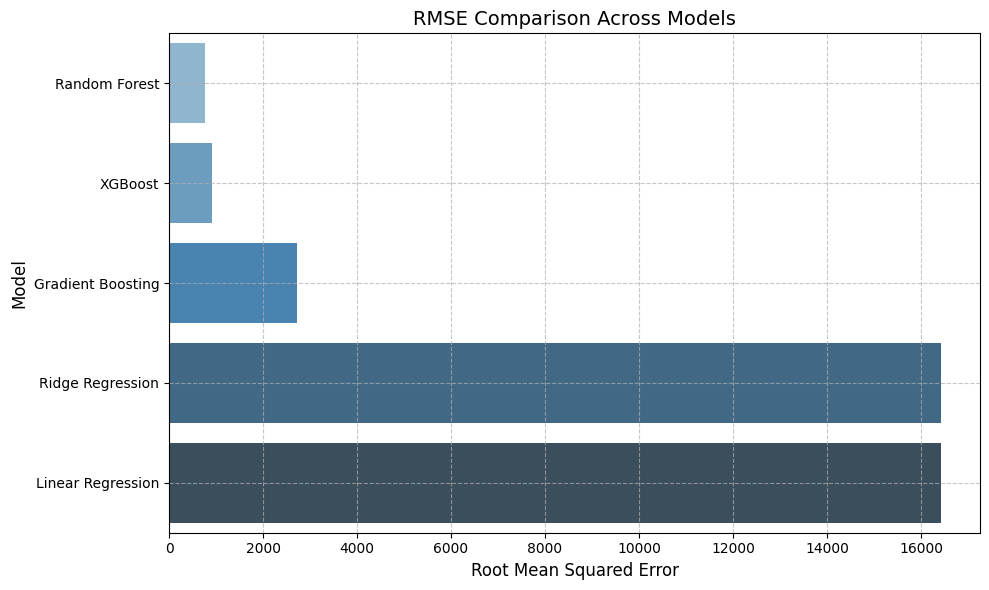

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='Blues_d')
plt.title('RMSE Comparison Across Models', fontsize=14)
plt.xlabel('Root Mean Squared Error', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save for upload
plt.tight_layout()
plt.savefig("rmse_bar_chart.png", dpi=300)
plt.show()

In [39]:
r2_results = {
    'Linear Regression': r2_score(y_test, y_pred_lr),
    'Ridge Regression': r2_score(y_test, y_pred_ridge),
    'Random Forest': r2_score(y_test, y_pred_rf),
    'XGBoost': r2_score(y_test, y_pred_xgb),
    'Gradient Boosting': r2_score(y_test, y_pred_gb)
}

r2_df = pd.DataFrame(list(r2_results.items()), columns=['Model', 'R2_Score'])
r2_df.sort_values('R2_Score', inplace=True)


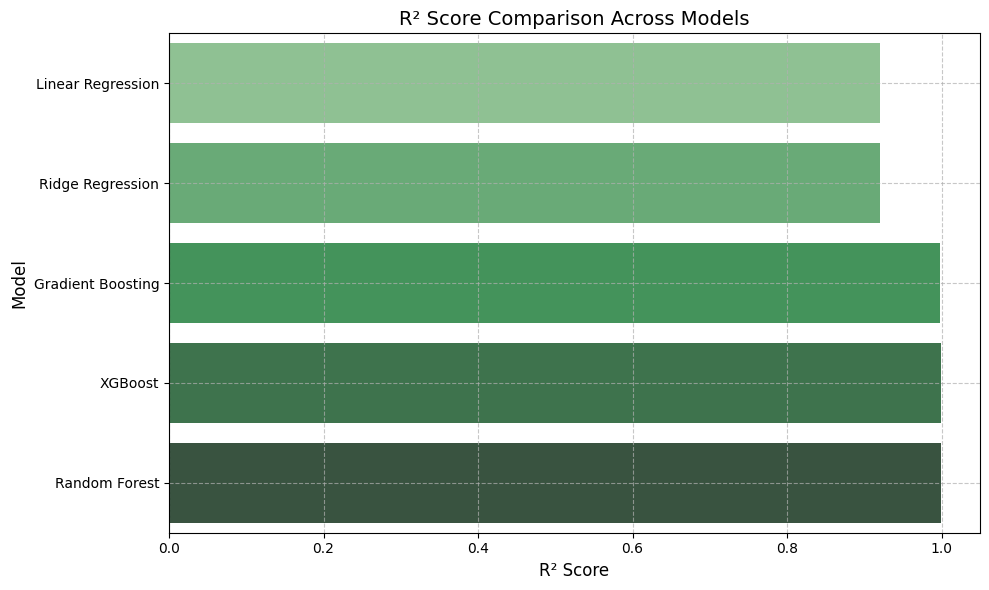

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='R2_Score', y='Model', data=r2_df, palette='Greens_d')
plt.title('R² Score Comparison Across Models', fontsize=14)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save for upload
plt.tight_layout()
plt.savefig("r2_score_bar_chart.png", dpi=300)
plt.show()


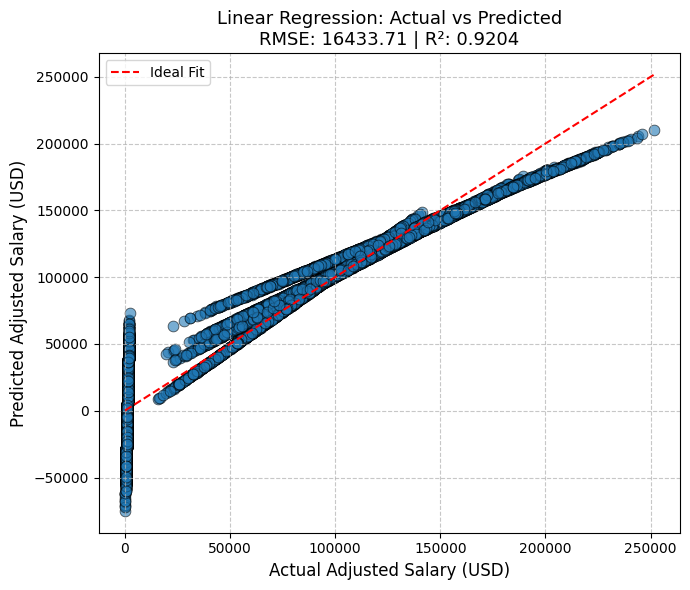

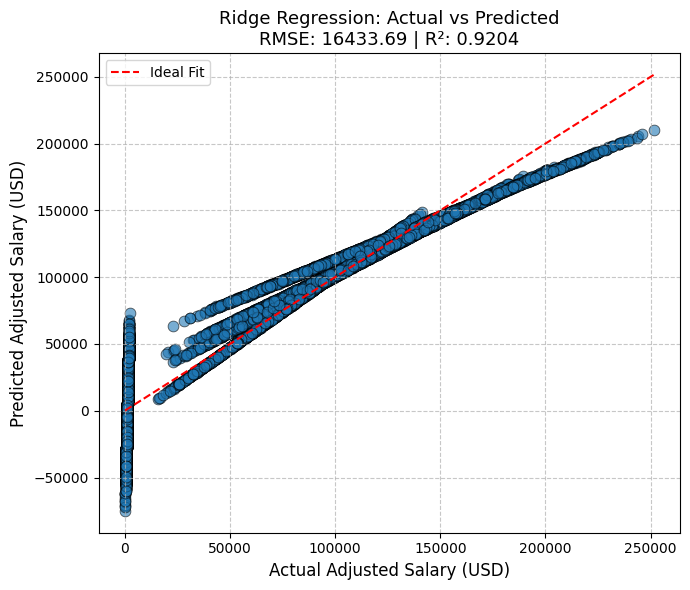

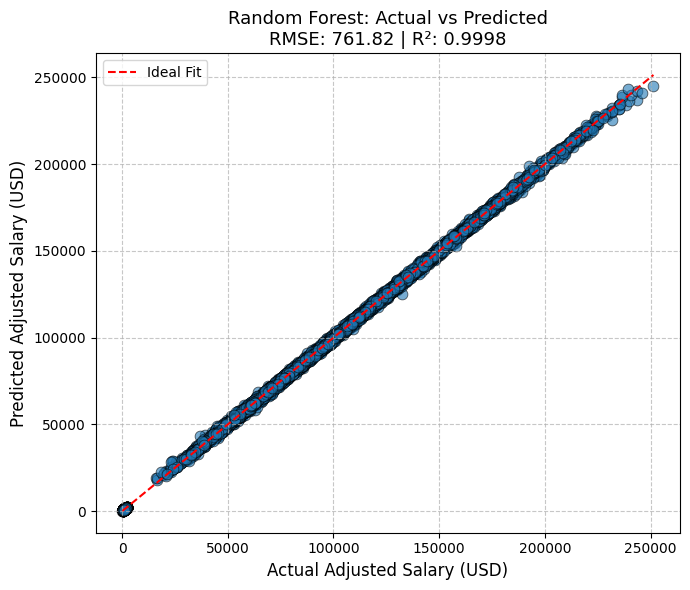

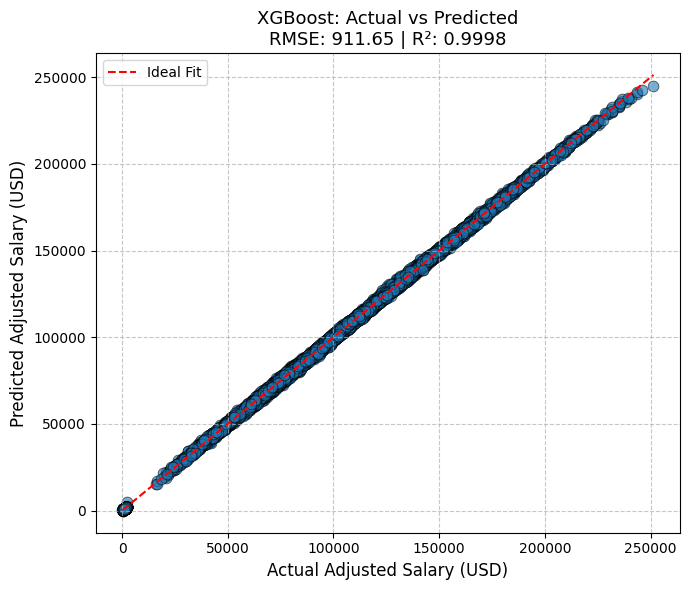

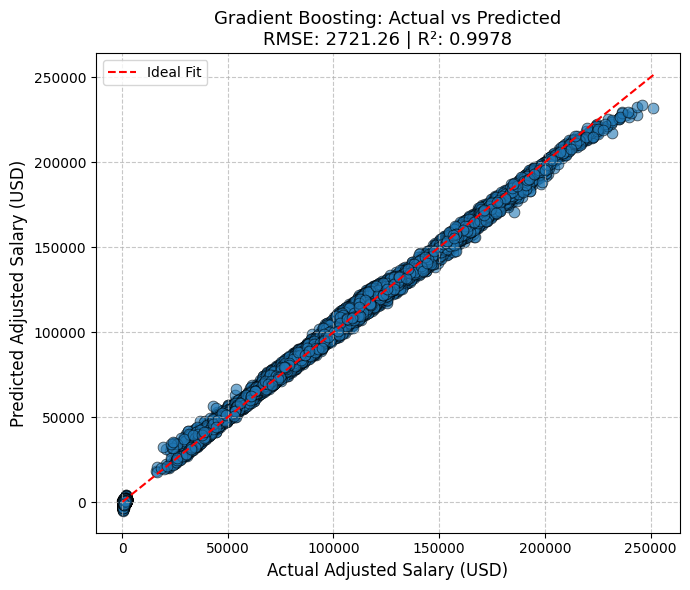

In [41]:
# Dictionary of model predictions
model_preds = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Gradient Boosting': y_pred_gb
}

# Plot Actual vs Predicted for each model
for model_name, y_pred in model_preds.items():
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60, edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Ideal Fit")
    plt.xlabel("Actual Adjusted Salary (USD)", fontsize=12)
    plt.ylabel("Predicted Adjusted Salary (USD)", fontsize=12)
    plt.title(f"{model_name}: Actual vs Predicted\nRMSE: {rmse:.2f} | R²: {r2:.4f}", fontsize=13)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    filename = model_name.lower().replace(" ", "_").replace(".", "") + "_actual_vs_predicted.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


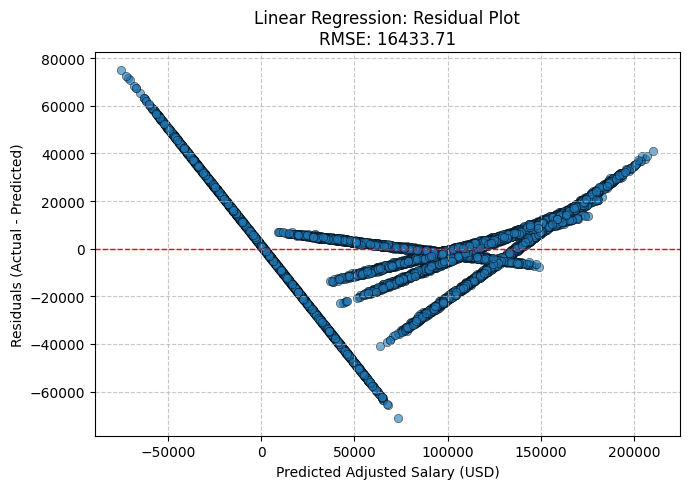

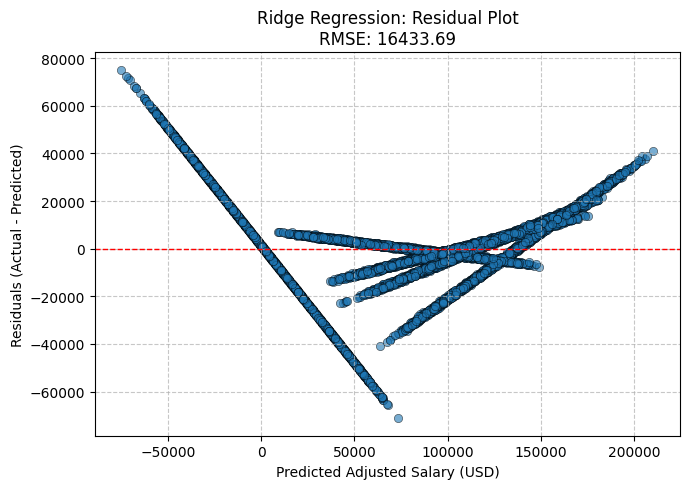

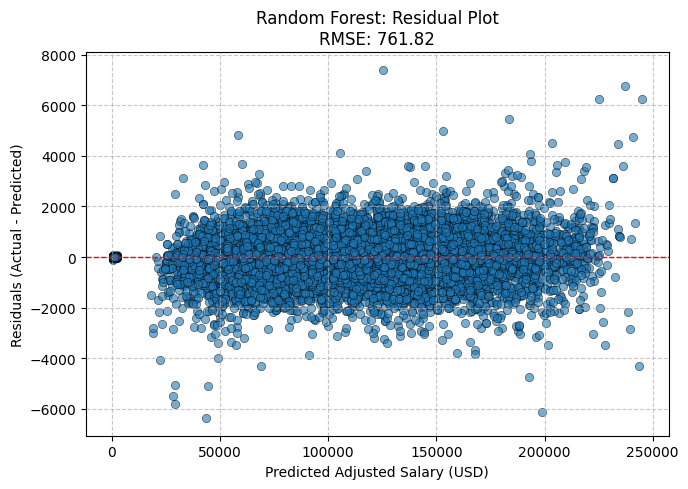

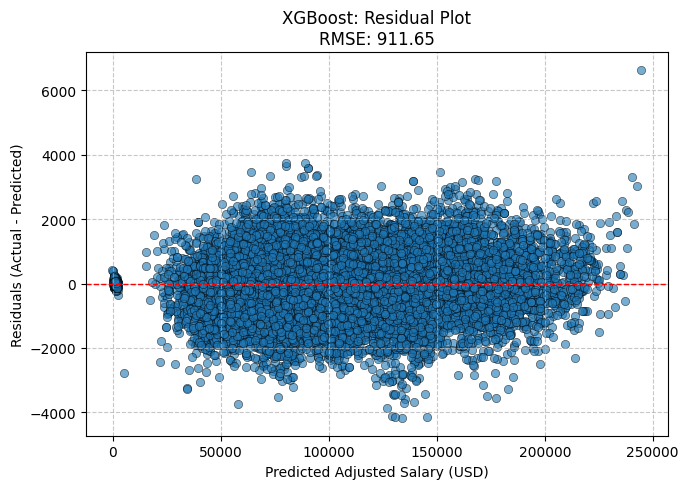

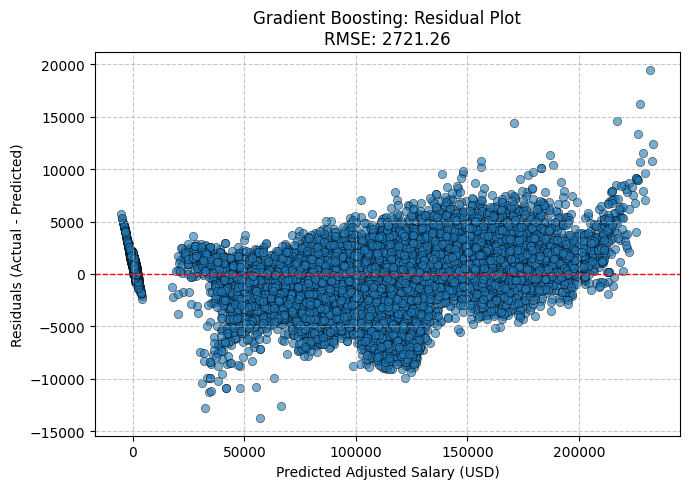

In [42]:
# True target
y_true = y_test

# Model predictions dictionary
model_predictions = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Gradient Boosting': y_pred_gb
}

# Plot residuals
for model_name, y_pred in model_predictions.items():
    residuals = y_true - y_pred
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='r', linestyle='--', linewidth=1)
    plt.xlabel("Predicted Adjusted Salary (USD)")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"{model_name}: Residual Plot\nRMSE: {rmse:.2f}")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save plot
    filename = model_name.lower().replace(" ", "_") + "_residual_plot.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


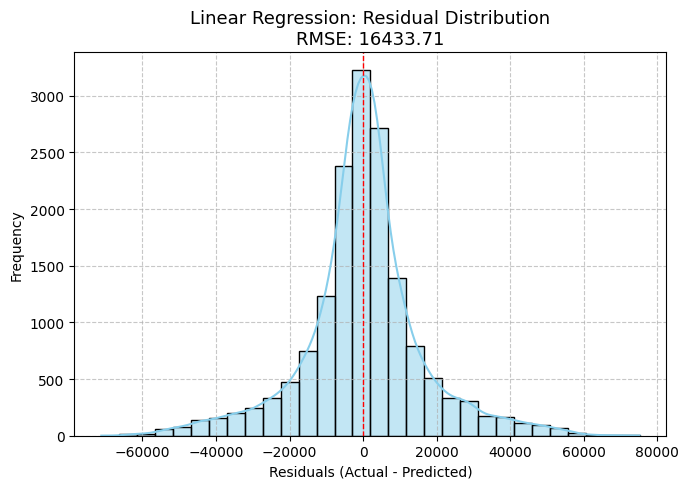

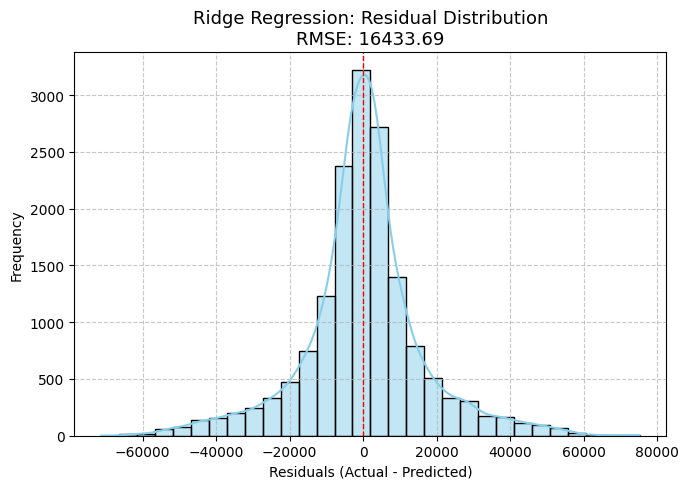

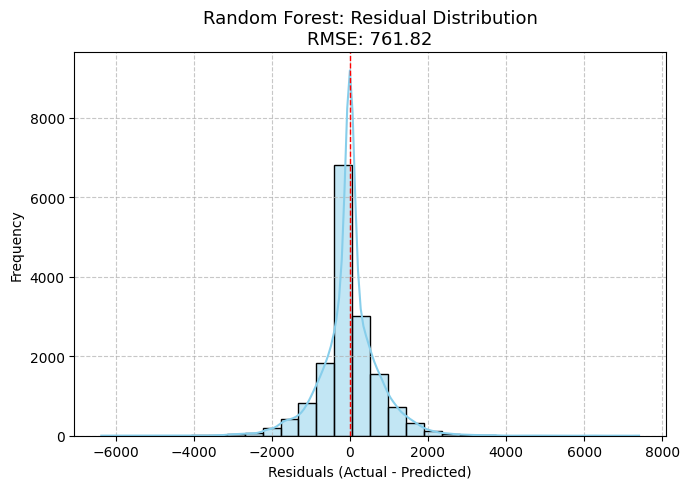

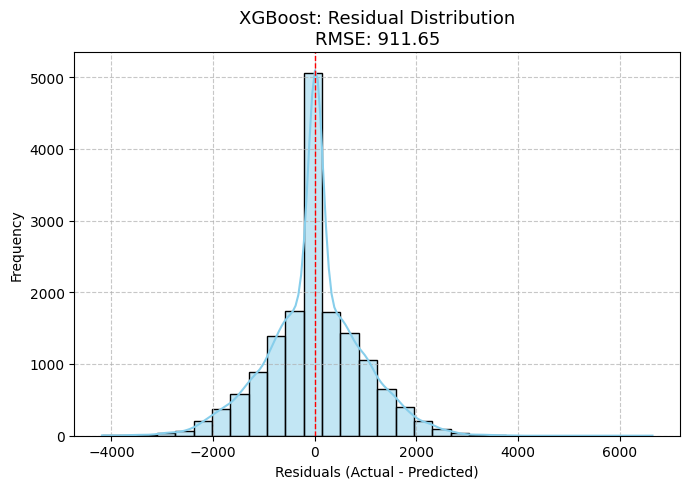

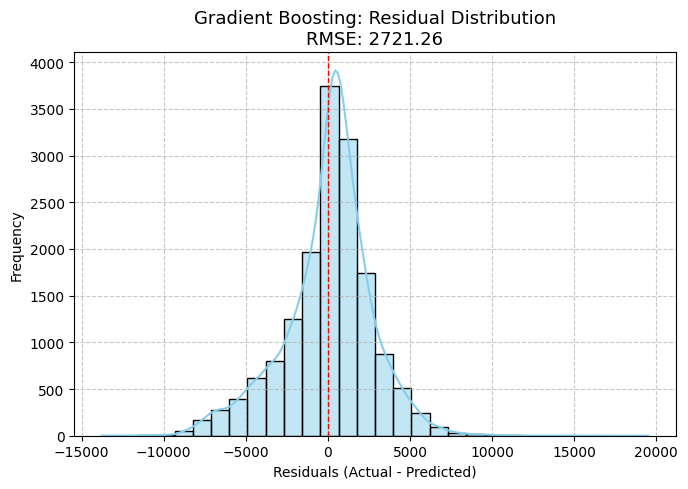

In [43]:
# Dictionary of predictions for each model
model_predictions = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Gradient Boosting': y_pred_gb
}

# Loop over models and plot residual distributions
for model_name, y_pred in model_predictions.items():
    residuals = y_test - y_pred
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    plt.figure(figsize=(7, 5))
    sns.histplot(residuals, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"{model_name}: Residual Distribution\nRMSE: {rmse:.2f}", fontsize=13)
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the plot
    filename = model_name.lower().replace(" ", "_") + "_residual_distribution.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


## Results

In [44]:
# Define bins and labels
bins = [0, 100000, 200000, float('inf')]
labels = ['Low', 'Medium', 'High']

# Bin the actual target values and convert to string
y_test_binned = pd.cut(y_test, bins=bins, labels=labels).astype(str)

# Model predictions dictionary
model_predictions = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Gradient Boosting': y_pred_gb
}

# Generate classification reports
for model_name, y_pred in model_predictions.items():
    y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels).astype(str)

    # Generate classification report
    report = classification_report(y_test_binned, y_pred_binned, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    
    print(f"\n Classification Report: {model_name}\n")
    display(report_df)


 Classification Report: Linear Regression



,precision,recall,f1-score,support
High,1.000000,0.043344,0.083086,323.000000
Low,1.000000,0.759196,0.863117,9107.000000
Medium,0.872819,1.000000,0.932091,6554.000000
nan,0.000000,0.000000,0.000000,0.000000
accuracy,0.843468,0.843468,0.843468,0.843468
macro avg,0.718205,0.450635,0.469574,15984.000000
weighted avg,0.947851,0.843468,0.875636,15984.000000



 Classification Report: Ridge Regression



,precision,recall,f1-score,support
High,1.000000,0.043344,0.083086,323.000000
Low,1.000000,0.759196,0.863117,9107.000000
Medium,0.872819,1.000000,0.932091,6554.000000
nan,0.000000,0.000000,0.000000,0.000000
accuracy,0.843468,0.843468,0.843468,0.843468
macro avg,0.718205,0.450635,0.469574,15984.000000
weighted avg,0.947851,0.843468,0.875636,15984.000000



 Classification Report: Random Forest



,precision,recall,f1-score,support
High,0.972477,0.984520,0.978462,323.000000
Low,0.996490,0.997474,0.996982,9107.000000
Medium,0.995719,0.993744,0.994731,6554.000000
accuracy,0.995683,0.995683,0.995683,0.995683
macro avg,0.988229,0.991913,0.990058,15984.000000
weighted avg,0.995689,0.995683,0.995685,15984.000000



 Classification Report: XGBoost



,precision,recall,f1-score,support
High,0.987539,0.981424,0.984472,323.000000
Low,0.996259,0.994290,0.995274,9107.000000
Medium,0.991479,0.994202,0.992839,6554.000000
nan,0.000000,0.000000,0.000000,0.000000
accuracy,0.993994,0.993994,0.993994,0.993994
macro avg,0.743819,0.742479,0.743146,15984.000000
weighted avg,0.994123,0.993994,0.994057,15984.000000



 Classification Report: Gradient Boosting



,precision,recall,f1-score,support
High,1.000000,0.904025,0.949593,323.000000
Low,0.990859,0.892720,0.939233,9107.000000
Medium,0.970491,0.988557,0.979441,6554.000000
nan,0.000000,0.000000,0.000000,0.000000
accuracy,0.932245,0.932245,0.932245,0.932245
macro avg,0.740338,0.696325,0.717067,15984.000000
weighted avg,0.982692,0.932245,0.955929,15984.000000


In [45]:
# Dictionary of model predictions
model_predictions = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Gradient Boosting': y_pred_gb
}

# Create summary list
model_summary = []

for model_name, y_pred in model_predictions.items():
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    model_summary.append({
        'Model': model_name,
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 4)
    })

# Convert to DataFrame and sort
summary_df = pd.DataFrame(model_summary).sort_values(by='RMSE')
print("\n Model Performance Summary (Regression Metrics):")
display(summary_df)



 Model Performance Summary (Regression Metrics):


,Model,RMSE,R² Score
2,Random Forest,761.82,0.9998
3,XGBoost,911.65,0.9998
4,Gradient Boosting,2721.26,0.9978
1,Ridge Regression,16433.69,0.9204
0,Linear Regression,16433.71,0.9204


## Ml flow

In [46]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="RandomForestRegressor"):
    # Log parameters
    mlflow.log_param("model", "RandomForestRegressor")
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("rmse", rmse_rf)
    mlflow.log_metric("r2", r2_rf)

    # Log the trained pipeline
    mlflow.sklearn.log_model(pipeline_rf, "random_forest_pipeline")

    print("✅ Logged to MLflow.")

2025/07/07 11:41:44 INFO mlflow.tracking.fluent: Experiment with name 'Salary Prediction' does not exist. Creating a new experiment.
2025/07/07 11:41:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:41:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged to MLflow.


In [47]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="LinearRegression"):
    # Log parameters
    mlflow.log_param("model", "LinearRegression")

    # Log metrics
    mlflow.log_metric("rmse", rmse_lr)
    mlflow.log_metric("r2", r2_lr)

    # Log the trained pipeline
    mlflow.sklearn.log_model(pipeline_lr, "linear_regression_pipeline")

    print("✅ Linear Regression logged to MLflow.")

2025/07/07 11:42:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:42:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Linear Regression logged to MLflow.


In [48]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="RidgeRegression"):
    # Log parameters
    mlflow.log_param("model", "Ridge")
    mlflow.log_param("alpha", 1.0)  # Match the alpha used in Ridge()

    # Log metrics
    mlflow.log_metric("rmse", rmse_ridge)
    mlflow.log_metric("r2", r2_ridge)

    # Log the model
    mlflow.sklearn.log_model(pipeline_ridge, "ridge_regression_pipeline")

    print("✅ Ridge Regression logged to MLflow.")

2025/07/07 11:42:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:42:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Ridge Regression logged to MLflow.


In [49]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="XGBoostRegressor"):
    # Log parameters
    mlflow.log_param("model", "XGBoostRegressor")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("rmse", rmse_xgb)
    mlflow.log_metric("r2", r2_xgb)

    # Log the model pipeline
    mlflow.sklearn.log_model(pipeline_xgb, "xgboost_pipeline")

    print("✅ XGBoost Regressor logged to MLflow.")


2025/07/07 11:42:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:42:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ XGBoost Regressor logged to MLflow.


In [50]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="GradientBoostingRegressor"):
    # Log parameters
    mlflow.log_param("model", "GradientBoostingRegressor")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("rmse", rmse_gb)
    mlflow.log_metric("r2", r2_gb)

    # Log the model pipeline
    mlflow.sklearn.log_model(pipeline_gb, "gradient_boosting_pipeline")

    print("✅ Gradient Boosting Regressor logged to MLflow.")

2025/07/07 11:42:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:42:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Gradient Boosting Regressor logged to MLflow.


In [51]:
# Register model
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="Register_RandomForest"):
    # Log model
    mlflow.sklearn.log_model(pipeline_rf, artifact_path="random_forest_pipeline")

    # Register model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/random_forest_pipeline"
    model_name = "Best_Salary_Predictor_RF"
    
    mlflow.register_model(model_uri=model_uri, name=model_name)

    print(f"✅ Registered model '{model_name}' successfully.")

2025/07/07 11:42:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 11:42:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_Salary_Predictor_RF'.
2025/07/07 11:42:24 WARNING mlflow.tracking._model_registry.fluent: Run with id 4d9c39d7b0554a4bb4196626cedb079a has no artifacts at artifact path 'random_forest_pipeline', registering model based on models:/m-3ba3887fe4fb47db8067614a74d232f9 instead


✅ Registered model 'Best_Salary_Predictor_RF' successfully.


Created version '1' of model 'Best_Salary_Predictor_RF'.


## Data Drift

In [52]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [53]:
# Create the report
data_drift_report = Report(metrics=[
    DataDriftPreset()
])

# Generate report
data_drift_report.run(reference_data=X_train, current_data=X_test)

# Save to HTML
data_drift_report.save_html("data_drift_report.html")

print("✅ Data Drift report saved as 'data_drift_report.html'")


✅ Data Drift report saved as 'data_drift_report.html'


In [54]:
#  Model Drift 
train_with_target = X_train.copy()
train_with_target['target'] = y_train

test_with_target = X_test.copy()
test_with_target['target'] = y_test

# Create and run the target drift report
target_drift_report = Report(metrics=[
    TargetDriftPreset()
])

target_drift_report.run(reference_data=train_with_target, current_data=test_with_target)

# Save the report as HTML
target_drift_report.save_html("target_drift_report.html")

print("✅ Target Drift Report saved as 'target_drift_report.html'")

✅ Target Drift Report saved as 'target_drift_report.html'


In [55]:
#  Concept Drift 
concept_drift_report = Report(metrics=[
    TargetDriftPreset()
])
concept_drift_report.run(
    reference_data=X_train.assign(target=y_train),
    current_data=X_test.assign(target=y_test)
)
concept_drift_report.save_html("concept_drift_report.html")
print(" Concept Drift report saved.")

 Concept Drift report saved.


In [56]:
mlflow.set_experiment("Salary Prediction")

with mlflow.start_run(run_name="Data Drift Check"):
    # Log the HTML file as an artifact
    mlflow.log_artifact("data_drift_report.html")

    print("✅ Data Drift report logged to MLflow.")

✅ Data Drift report logged to MLflow.


## Saving The Best Model

In [ ]:
import os
import joblib

# Create the folder if it doesn't exist
os.makedirs("model", exist_ok=True)

# Save the model
joblib.dump(pipeline_rf, "model/model.pkl")
print("✅ Model saved to model/model.pkl")


✅ Model saved to model/model.pkl
